# Fitting a Gradient Boosting Machine (GBM) and publishing to AzureML using R

## Introduction
In this notebook you fit a Gradient Boosting Machine (GBM) model using R, and then publish the model as a web service on the Azure Machine Learning platform.

### Target audience
You should have some experience with R and know a little about Azure ML web services

### Why GBM in R notebooks
GBM is well-known among data scientists and as a [Kaggle Profile][kaggle link] explains, it has several major advantages compared with traditional statistical models like linear regression:
* it automatically approximates non-linear transformations and interactions
* it treats missing values without having to fill in values or remove observations
* monotonic transformation of features won't influence the model's performance

[kaggle link]: http://blog.kaggle.com/2015/06/22/profiling-top-kagglers-owen-zhang-currently-1-in-the-world/

For users who are used to fitting GBM models in Azure ML Experiments, a major advantage of using Azure ML notebooks is that there are more modeling options. For example, when the response variable is continunous you can use the "Boosted Decision Tree Regression" module for Experiments to fit a GBM model. This module, however, does not allow users to specify the types of loss functions (for statisticians, this means that you can't specify the distribution for the response variable). On the other hand, with the `gbm` package in R, you can choose from a wide variety of loss functions. 

## Data
In this example, you use the housing data from the R package `MASS`. There are 506 rows and 14 columns in the dataset. Available information includes median home price, average number of rooms per dwelling, crime rate by town, etc. Find more information about this dataset typing `help(Boston)` or `?Boston` in an R terminal, or at this [UCI page][UCI link].

[uci link]: https://archive.ics.uci.edu/ml/datasets/Housing


In [1]:
library(MASS) # to use the Boston dataset
?Boston

No documentation for 'Boston' in specified packages and libraries:
you could try '??Boston'

## GBM model
### Estimate hyperparameters
In a GBM model, there are several hyperparameters and we need to estimate them first. One way to estimate these parameters is to use cross validation on a parameter-grid. In our example, we'll optimize the following parameters over a grid: number of estimators, maximum tree depth, minimum number of samples on a split, and learning rate. To do this we start by providing several values for each of them and create a set of combinations, each combination consisting of one value for each parameter. Then for each combination we use cross validation to estimate the performance, using root mean squared error as performance metric. The "caret" package will be used in this process.



In [2]:
# load the libraries
if(!require("gbm")) install.packages("gbm")
library(gbm)

Warning message:
: package 'MASS' was built under R version 3.2.3Warning message:
: package 'gbm' was built under R version 3.2.3Loading required package: survival
Loading required package: splines
Loading required package: parallel
Loaded gbm 2.1.1


In [3]:
model1 <- gbm(medv ~ ., data = Boston, 
            distribution = "gaussian",
            n.trees = 5000,
            interaction.depth = 2, 
            n.minobsinnode = 1, 
            shrinkage = 0.001)


,var,rel.inf
lstat,lstat,42.40815
rm,rm,37.56727
dis,dis,7.985178
crim,crim,4.02818
nox,nox,3.488242
ptratio,ptratio,2.775456
tax,tax,0.8367165
age,age,0.3748081
chas,chas,0.1964425
black,black,0.1819871


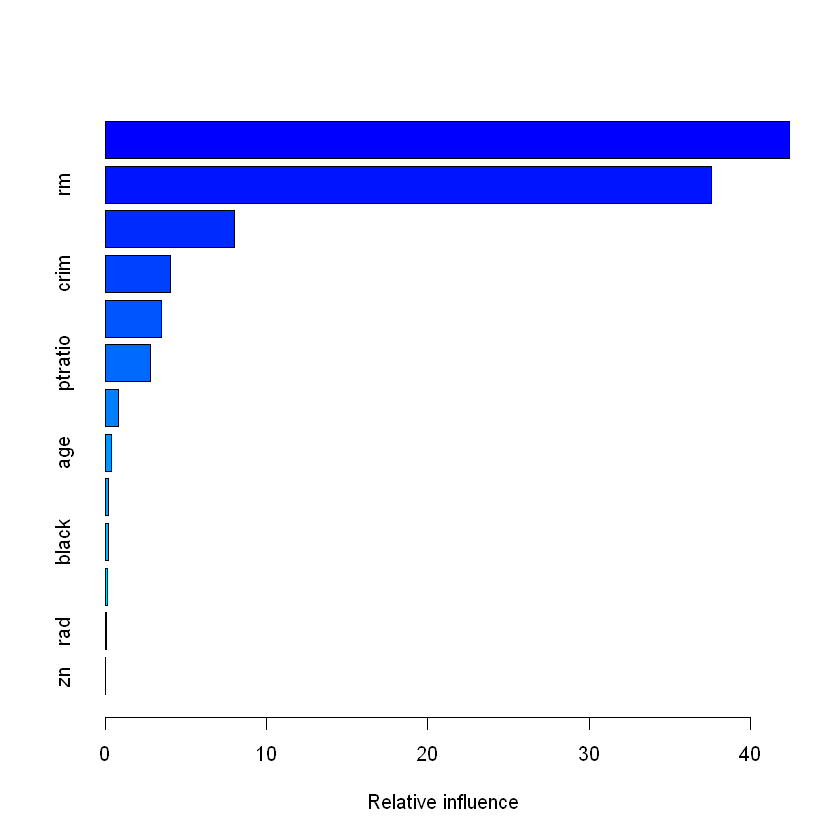

In [4]:
# summarize the model
options(repr.plot.width = 4, repr.plot.height = 4)
summary(model1)

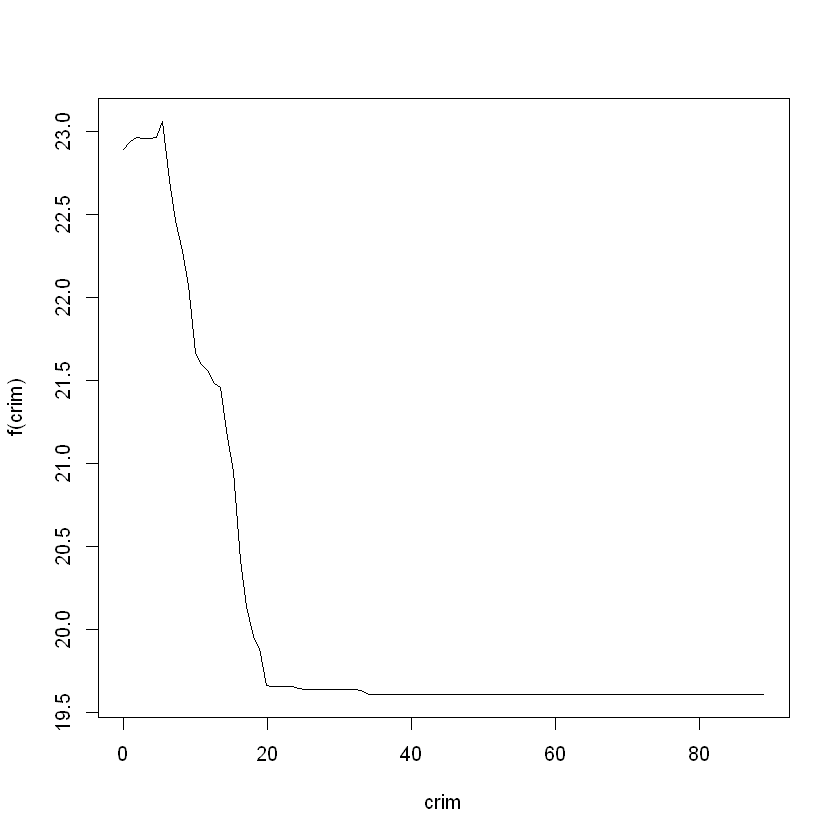

In [5]:
# plot cv results
plot(model1)

### Fit Model with Estimated Parameters
With the selected parameter values from above, we can fit a GBM model.

,var,rel.inf
lstat,lstat,37.72131
rm,rm,32.2404
dis,dis,9.14701
crim,crim,5.212688
nox,nox,3.867319
ptratio,ptratio,3.336715
age,age,2.475507
black,black,2.08439
tax,tax,1.884501
indus,indus,0.8155508


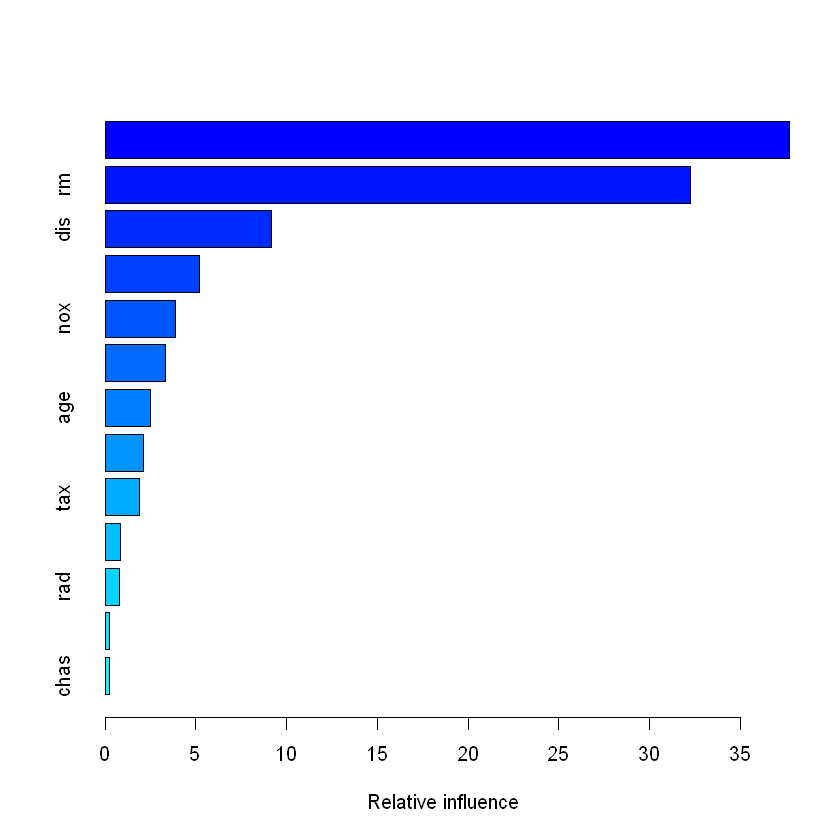

In [6]:
# fit the model

model2 <- gbm(medv ~ ., data = Boston, 
            distribution = "gaussian",
            n.trees = 10000,
            interaction.depth = 4, 
            n.minobsinnode = 1, 
            shrinkage = 0.01)

summary(model2)



For the fitted model,we can look closely at how the number of trees affect loss function on training and validation data to select the best value.

## Web service
### Deploy a web service
With the developed model, we can deploy a web service so that others can use it to make predictions. The "AzureML" package will be used for this purpose. 

In [7]:
# load the library
library(AzureML)

# workspace information
ws <- workspace()

# define predict function
predict_gbm <- function(newdata){
  require(gbm)
  predict(model2, newdata, n.trees = 1000)
}

# test the prediction function
newdata <- Boston[1:10, ]
pred <- predict_gbm(newdata)

data.frame(actual = newdata$medv, prediction = pred)

Warning message:
: package 'AzureML' was built under R version 3.2.3

,actual,prediction
1,24,25.92935
2,21.6,21.88954
3,34.7,34.35476
4,33.4,34.62983
5,36.2,33.63816
6,28.7,26.69951
7,22.9,21.37308
8,27.1,20.73458
9,16.5,16.23034
10,18.9,18.36818


In [8]:
# Publish the service
ep <- publishWebService(ws = ws, fun = predict_gbm, 
                        name = "HousePricePredictionGBM", 
                        inputSchema = newdata)
str(ep)

Classes 'Endpoint' and 'data.frame':	1 obs. of  14 variables:
 $ Name                 : chr "default"
 $ Description          : chr ""
 $ CreationTime         : chr "2016-03-13T16:19:55.06Z"
 $ WorkspaceId          : chr "a2aba0dafad8436788401bbc8c22fe36"
 $ WebServiceId         : chr "5d78b508e93711e5a09b9be0b5519e78"
 $ HelpLocation         : chr "https://studio.azureml-int.net/apihelp/workspaces/a2aba0dafad8436788401bbc8c22fe36/webservices/5d78b508e93711e5a09b9be0b5519e78"| __truncated__
 $ PrimaryKey           : chr "G0fn3BdxtiTSanKT5FaAg7YhCGJTz4C2Lqxxfx1d5R9QS3u1ecNLzXpJujvdaopFWhVJIUKe/9EOJviJRVO7aQ=="
 $ SecondaryKey         : chr "fr6iGQBRx0C1AWuhOKDzAo31boQorwc3oKaDjDeILU+OmYI+BJ8woGU0T8erb+4i9s+2tr9kY22CsvR+Ep/+qQ=="
 $ ApiLocation          : chr "https://ussouthcentral.services.azureml-int.net/workspaces/a2aba0dafad8436788401bbc8c22fe36/services/c95a1777e055426d97315a5e20"| __truncated__
 $ PreventUpdate        : logi FALSE
 $ GlobalParameters     :List of 1
  ..$ : list()


### Consume a web service

With information about the workspace and and service ID, we can consume the web service with the following code.

In [9]:
pred <- consume(ep, newdata)$ans
data.frame(actual = newdata$medv, prediction = pred)

,actual,prediction
1,24,25.92935
2,21.6,21.88954
3,34.7,34.35476
4,33.4,34.62983
5,36.2,33.63816
6,28.7,26.69951
7,22.9,21.37308
8,27.1,20.73458
9,16.5,16.23034
10,18.9,18.36818


## Conclusion
Using the `Boston` housing dataset, we started the analysis by estimating the parameters in the GBM model. Then we fitted the model and examined variable importance. A web service was also deployed based on the selected model.

In addition to the Gaussian distribution which uses squared error loss function, the `gbm` package allows for several other distributions: laplace which uses absolute loss, t-distribution which uses t-distribution loss, etc. 

The `caret` package makes it possible to easily tune the hyperparameters on a grid. 

---  
Created by a Microsoft Employee.  
Copyright (C) Microsoft. All Rights Reserved.